# Examples of cartopy.

+++ +++ +++

**Second version of this script.** Issues with repo required a second upload. This file is not the original, however, it was a tutorial follow-along from the following website: https://nbviewer.jupyter.org/github/mccrayc/tutorials/blob/master/2_reanalysis/CFSR_Data_Tutorial.ipynb

Data upload: https://www.cdmccray.com/python.html

+++ +++ +++
## Code for 1993 "Storm of the Centure" reanalysis,

In [4]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (12, 12)

dataFile = 'pgbh00.gdas.1993031412.nc'
#Open the dataset and print out metadeta
ds = xr.open_dataset(dataFile)
print (ds)
#Convert pressure from Pa to hPa
ds['pressure'] = ds['pressure']/100

#Only pulling out pressure and vorticity data
lat = ds['lat']
lon = ds['lon']
hght = ds['Geopotential_height'].sel(pressure=500).isel(time=0)
avor = ds['Absolute_vorticity'].sel(pressure=500).isel(time=0)

#Creating a map generating function
def plotMap():
    #Set the projection information
    proj = ccrs.LambertConformal(central_longitude=-97.0,central_latitude=53, standard_parallels=[53])
    #Create a figure with an axes object on which we will plot. Pass the projection to that axes.
    fig, ax = plt.subplots(subplot_kw=dict(projection=proj))
    
    #Zoom in
    ax.set_extent([-45, -155, 10, 90])
    
    #Add map features
    ax.add_feature(cfeature.LAND, facecolor='0.9') #Grayscale colors can be set using 0 (black) to 1 (white)
    ax.add_feature(cfeature.LAKES, alpha=0.9)  #Alpha sets transparency (0 is transparent, 1 is solid)
    ax.add_feature(cfeature.BORDERS, zorder=10) #Zorder defines which layer order this feature will display
    ax.add_feature(cfeature.COASTLINE, zorder=10)

    #We can use additional features from Natural Earth (http://www.naturalearthdata.com/features/)
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray', zorder=10)
    
    #Add lat/lon gridlines every 20° to the map
    ax.gridlines(xlocs=np.arange(0,361,20), ylocs=np.arange(-80,90,20)) 
    
    return fig, ax

<xarray.Dataset>
Dimensions:                  (time: 1, lat: 201, lon: 720, pressure: 37)
Coordinates:
  * time                     (time) datetime64[ns] 1993-03-14T12:00:00
  * lat                      (lat) float64 90.0 89.5 89.0 ... -9.0 -9.5 -10.0
  * lon                      (lon) float64 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
  * pressure                 (pressure) float64 1e+05 9.75e+04 ... 200.0 100.0
Data variables:
    Pressure_reduced_to_MSL  (time, lat, lon) float32 ...
    Absolute_vorticity       (time, pressure, lat, lon) float32 ...
    Geopotential_height      (time, pressure, lat, lon) float32 ...
    Temperature              (time, pressure, lat, lon) float32 ...
    U-component_of_wind      (time, pressure, lat, lon) float32 ...
    V-component_of_wind      (time, pressure, lat, lon) float32 ...
Attributes:
    Conventions:                  CF-1.0
    Originating_center:           US National Weather Service (NCEP) subcente...
    Generating_Process_or_Model:  Foreca

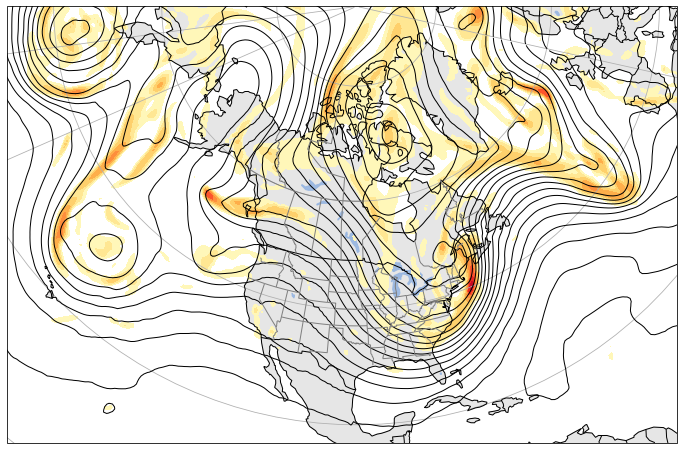

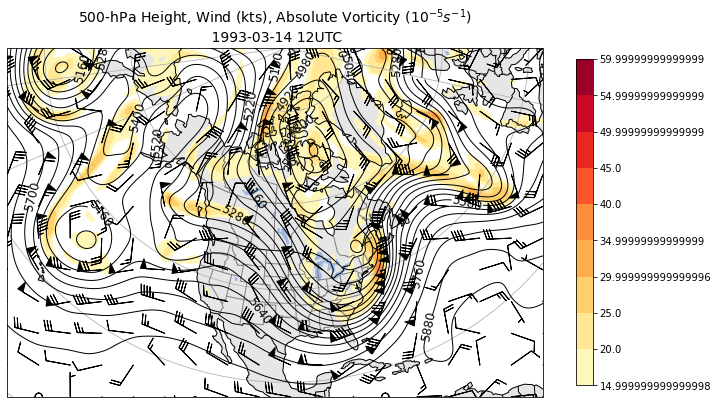

In [5]:
#Get a new background map figure
fig, ax = plotMap()

#Plot the 500-hPa height contours on the map, in black, with line width 1, and plot it above everything else.
hght_levels = np.arange(4320,6000,60)
ax.contour(lon, lat,hght, colors='k', levels=hght_levels, linewidths=1, zorder=3, transform = ccrs.PlateCarree())

#Now plot absolute vorticity as filled contours underneath height field, only values above 1.5e-4 s-1, 
# and use the YlOrRd colormap.
avor_levels = np.linspace(15e-5,60e-5, 10)
avor_contour = ax.contourf(lon, lat, avor, levels = avor_levels,  
                           cmap=plt.cm.YlOrRd, zorder=2, transform = ccrs.PlateCarree())

#Import scipy.ndimage to get the gaussian_filter function
import scipy.ndimage as ndimage

#Plot a new figure and map axes
fig, ax = plotMap()

#Smooth and re-plot the vorticity field
avor_smooth = ndimage.gaussian_filter(avor, sigma=1.5, order=0)
avor_contour = ax.contourf(lon, lat, avor_smooth, levels = avor_levels, zorder=2,  
                           cmap=plt.cm.YlOrRd, transform = ccrs.PlateCarree())

#Smooth and re-plot the height field
hght_smooth = ndimage.gaussian_filter(hght, sigma=3, order=0)
hght_contour = ax.contour(lon, lat, hght_smooth, levels=hght_levels, linewidths=1, colors='k',  
                          zorder=11,transform = ccrs.PlateCarree())

#Plot contour labels for the heights, leaving a break in the contours for the text (inline=True)
plt.clabel(hght_contour,  hght_levels, inline=True, fmt='%1i', fontsize=12)

#Create a colorbar and shrink it down a bit.
cb = plt.colorbar(avor_contour, shrink=0.5)
#Change the tick labels
cb.set_ticklabels(avor_levels*10**5)

#Get the wind components
urel = ds['U-component_of_wind'].sel(pressure=500).isel(time=0).values*1.944
vrel = ds['V-component_of_wind'].sel(pressure=500).isel(time=0).values*1.944

#Plot the barbs
ax.barbs(lon, lat, urel, vrel, regrid_shape=12, zorder=20, transform=ccrs.PlateCarree())

ax.set_title('500-hPa Height, Wind (kts), Absolute Vorticity ($10^{-5} s^{-1}$)\n 1993-03-14 12UTC', fontsize=14)

fig



plt.savefig('500_heights_winds_vort_930313_00.png', bbox_inches='tight')